# Using Variational Autoencoder to Generate Faces

In this example, we are going to use VAE to generate faces. The dataset we are going to use is [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). The dataset consists of more than 200K celebrity face images. You have to download the Align&Cropped Images from the above website to run this example.

In [1]:
from zoo.pipeline.api.keras.layers import *
from zoo.pipeline.api.keras.models import Model
from zoo.pipeline.api.keras.utils import *
from utils import *
from glob import glob
import numpy as np

IMAGE_SIZE = 148
IMAGE_ROW = 64
IMAGE_COL = 64
Z_DIM = 128
ENCODER_FILTER_NUM = 32
IMAGE_CHANNELS = 3

#download the data CelebA, and may repalce with your own data path
DATA_PATH = os.getenv("ANALYTICS_ZOO_HOME") + "/apps/variational-autoencoder/img_align_celeba"
init_engine()

## Define the Model

Here, we define a slightly more complicate CNN networks using convolution, batchnorm, and leakyRelu.

In [2]:
def conv_bn_lrelu(out_channles, in_channels, in_row, in_col, kw=4, kh=4, sw=2, sh=2):
    input0 = Input(shape=(in_channels,in_row,in_col))
    conv1 = Convolution2D(out_channles, kw, kh, subsample=(sw, sh), border_mode='same')(input0)
    batch = BatchNormalization(out_channles)(conv1)
    relu = LeakyReLU(0.2)(batch)
    model = Model([input0], [relu])
    return model

def upsample_conv_bn_lrelu(out_channles, in_channels, in_row, in_col, out_width, out_height, kw=3, kh=3, sw=1, sh=1):
    input0 = Input(shape=(in_channels,in_col,in_row))
    resize = ResizeBilinear(out_width, out_height)(input0)
    conv1 = Convolution2D(out_channles, kw, kh, subsample=(sw, sh), border_mode='same')(resize)
    batch1 = BatchNormalization(out_channles)(conv1)
    relu = LeakyReLU(0.2)(batch1)
    model = Model([input0], [relu])
    return model


In [3]:
def get_encoder_cnn():
    input0 = Input(shape=(IMAGE_CHANNELS, IMAGE_ROW, IMAGE_COL))
    
    #conv
    conv1 = conv_bn_lrelu(ENCODER_FILTER_NUM, IMAGE_CHANNELS, IMAGE_ROW, IMAGE_COL)(input0)  # 32 * 32 * 32
    conv2 = conv_bn_lrelu(ENCODER_FILTER_NUM * 2,ENCODER_FILTER_NUM, 32, 32)(conv1)  # 16 * 16 * 64
    conv3 = conv_bn_lrelu(ENCODER_FILTER_NUM * 4,ENCODER_FILTER_NUM * 2, 16, 16)(conv2)  # 8 * 8 * 128
    conv4 = conv_bn_lrelu(ENCODER_FILTER_NUM * 8, ENCODER_FILTER_NUM * 4, 8, 8)(conv3)  # 4 * 4 * 256
    flatten = Flatten()(conv4)
    inter = Dense(2048)(flatten)
    inter = Reshape((1,1,2048))(inter)
    inter = BatchNormalization()(inter)
    inter = Activation('relu')(inter)
    inter = Flatten()(inter)
    
    # fully connected to generate mean and log-variance
    mean = Dense(Z_DIM)(inter)
    log_variance = Dense(Z_DIM)(inter)

    model = Model([input0], [mean, log_variance])
    return model


In [4]:
def get_decoder_cnn():
    input0 = Input(shape=(Z_DIM,))
    linear = Dense(2048)(input0)
    linear = Dense(4 * 4 * ENCODER_FILTER_NUM * 8)(linear)
    reshape = Reshape((ENCODER_FILTER_NUM * 8, 4, 4))(linear)
    bn = BatchNormalization(ENCODER_FILTER_NUM * 8)(reshape)

    # upsampling
    up1 = upsample_conv_bn_lrelu(ENCODER_FILTER_NUM * 4,ENCODER_FILTER_NUM * 8, 4, 4, 8, 8)(bn)  # 8 * 8 * 128
    up2 = upsample_conv_bn_lrelu(ENCODER_FILTER_NUM * 2,ENCODER_FILTER_NUM * 4, 8, 8, 16, 16)(up1)  # 16 * 16 * 64
    up3 = upsample_conv_bn_lrelu(ENCODER_FILTER_NUM, ENCODER_FILTER_NUM * 2, 16, 16, 32, 32)(up2)  # 32 * 32 * 32
    up4 = upsample_conv_bn_lrelu(IMAGE_CHANNELS, ENCODER_FILTER_NUM, 32,32, 64, 64)(up3)  # 64 * 64 * 3
    output = Activation('sigmoid')(up4)

    model = Model([input0], [output])
    return model

In [5]:
def get_autoencoder_cnn():
    input0 = Input(shape=(IMAGE_CHANNELS, IMAGE_ROW, IMAGE_COL))
    encoder = get_encoder_cnn()(input0)
    sampler = GaussianSampler()(encoder)

    decoder_model = get_decoder_cnn()
    decoder = decoder_model(sampler)
    model = Model([input0], [encoder, decoder])
    return model, decoder_model

In [6]:
autoencoder, decoder_model = get_autoencoder_cnn()

creating: createZooKerasInput
creating: createZooKerasInput
creating: createZooKerasInput
creating: createZooKerasConvolution2D
creating: createZooKerasBatchNormalization
creating: createZooKerasLeakyReLU
creating: createZooKerasModel
creating: createZooKerasInput
creating: createZooKerasConvolution2D
creating: createZooKerasBatchNormalization
creating: createZooKerasLeakyReLU
creating: createZooKerasModel
creating: createZooKerasInput
creating: createZooKerasConvolution2D
creating: createZooKerasBatchNormalization
creating: createZooKerasLeakyReLU
creating: createZooKerasModel
creating: createZooKerasInput
creating: createZooKerasConvolution2D
creating: createZooKerasBatchNormalization
creating: createZooKerasLeakyReLU
creating: createZooKerasModel
creating: createZooKerasFlatten
creating: createZooKerasDense
creating: createZooKerasReshape
creating: createZooKerasBatchNormalization
creating: createZooKerasActivation
creating: createZooKerasFlatten
creating: createZooKerasDense
creati

## Load the Dataset

In [8]:
def get_data():
    data_files = glob(os.path.join(DATA_PATH, "*.jpg"))

    rdd_train_images = sc.parallelize(data_files[:100000]) \
        .map(lambda path: inverse_transform(get_image(path, IMAGE_SIZE)).transpose(2, 0, 1))
    rdd_train_sample = rdd_train_images.map(lambda img: Sample.from_ndarray(img, [np.array(0.0), img]))
    return rdd_train_sample

In [9]:
from pyspark import SparkContext
sc =SparkContext.getOrCreate()
train_data = get_data()

## Define the Training Objective

In [10]:
batch_size = 100
criterion = ParallelCriterion()
criterion.add(KLDCriterion(), 1.0) # You may want to twick this parameter
criterion.add(BCECriterion(size_average=False), 1.0 / 64)

creating: createParallelCriterion
creating: createKLDCriterion
creating: createBCECriterion


## Compile the Model

In [12]:
autoencoder.compile(optimizer=Adam(0.001), loss=criterion)

import os
import datetime as dt
if not os.path.exists("./log"):
    os.makedirs("./log")
                
app_name='vae-faces-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
autoencoder.set_tensorboard(log_dir='./log/',app_name=app_name)

print("Saving logs to ", app_name)

creating: createAdam
('Saving logs to ', 'vae-faces-20180607-164759')


## Start Training

This could take a while. It took about 2 hours on a desktop with a intel i7-6700 cpu and 40GB java heap memory. You can reduce the training time by using less data (some changes in the "Load the Dataset" section), but the performce may not as good.

In [13]:
autoencoder.fit(x=train_data,
                batch_size=batch_size,
                nb_epoch = 6)

In [14]:
def gen_image_row():
    return np.column_stack([decoder_model.forward(np.random.randn(1, Z_DIM)).reshape(3, 64,64).transpose(1, 2, 0) for s in range(8)])

def gen_image():
    return np.row_stack([gen_image_row() for i in range(8)])


In [15]:
import matplotlib
matplotlib.use('Agg')
%pylab inline

from matplotlib.pyplot import imshow

Populating the interactive namespace from numpy and matplotlib


/home/wangzhiqi/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


creating: createTrainSummary


Text(0.5,1,'loss')

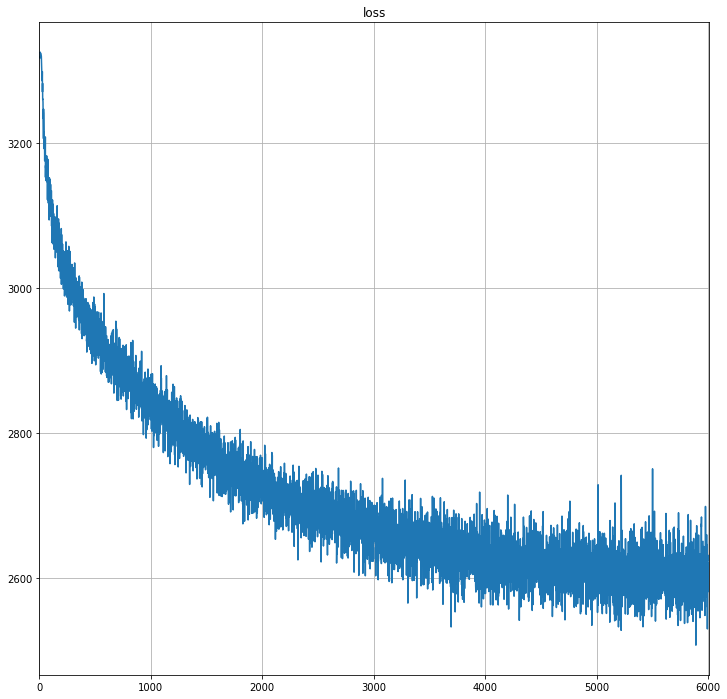

In [16]:
train_summary = TrainSummary('./log/', app_name)
loss = np.array(train_summary.read_scalar("Loss"))
plt.figure(figsize = (12,12))
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")

## Random Sample Some Images

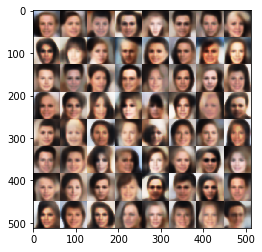

In [17]:
img = gen_image()
imshow(img)
